In [174]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_score, recall_score, roc_curve, roc_auc_score, accuracy_score, classification_report
from sklearn.dummy import DummyClassifier
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler

Why logistic regression?
    - Logistic regression is used for binary classification. This suits our project as we are classifying whether a tumour is malignant (M) or benign (B).

How will we evaluate the model?
   - Bias (how accurate the model is)
   - Variance (how spread out the predictions are from the mean)

(This shows us if our model is overfitting / underfitting), make graphs

Since it's a classification algorithm, we evaluate it with:
- Accuracy
- Precision
- Recall

Confusion matrix to see the distribution of TP, FP, TN, FN

IMPORTANT TODO:
- Cost of FN is much higher than TP, FP, TN
- IS MY MODEL OVERFITTING / UNDERFITTING? <- how can we check? (bias / variance tradeoff)
- Make heatmap of confusion matrix

Chi-squared tests to see which variables are useless?

https://www.kaggle.com/code/prashant111/logistic-regression-classifier-tutorial

In [175]:
df = pd.read_csv('./Data Exploration/wdbc.csv')
labels = df['B/M']
features = df[['Radius', 'Texture', 'Perimeter', 'Area', 'Smoothness', 'Compactness', 'Concavity', 'ConcavePoints', 'Symmetry', 'FractalDimension']]

In [176]:
# Standardize features
features[features.select_dtypes(['float64', 'int64']).columns.values] = ColumnTransformer([
        ('StandardScaler', StandardScaler(), features.columns.values)
    ]).fit_transform(df)

/home/nicky/Documents/CS/ai/ai_coursework/utils.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[columns if columns else df.select_dtypes(['float64', 'int64']).columns.values] = ColumnTransformer([


Distribution of B / M, we will use this result when comparing our model to a dummy model later

In [177]:
labels.value_counts()

B    357
M    212
Name: B/M, dtype: int64

In [178]:
# 80% train, 20% test
# todo: stratified sample
x_train, x_test, y_train, y_test = train_test_split(features, labels, test_size=0.25, random_state=0, stratify=labels)

In [179]:
# Fit model to training data
model = LogisticRegression().fit(x_train, y_train)
y_pred = model.predict(x_test)
# Accuracy
accuracy = model.score(x_test, y_test)

In [180]:
y_pred

array(['M', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B',
       'B', 'M', 'M', 'B', 'M', 'M', 'M', 'B', 'M', 'B', 'B', 'M', 'B',
       'B', 'M', 'B', 'M', 'B', 'M', 'B', 'M', 'B', 'M', 'B', 'M', 'B',
       'M', 'M', 'B', 'B', 'B', 'B', 'M', 'B', 'B', 'B', 'M', 'M', 'M',
       'M', 'B', 'B', 'B', 'B', 'B', 'B', 'M', 'M', 'M', 'B', 'B', 'M',
       'B', 'M', 'M', 'M', 'B', 'B', 'M', 'B', 'M', 'M', 'B', 'B', 'B',
       'B', 'B', 'M', 'M', 'M', 'B', 'M', 'B', 'B', 'B', 'M', 'M', 'B',
       'B', 'B', 'M', 'B', 'B', 'M', 'B', 'B', 'B', 'B', 'B', 'B', 'M',
       'M', 'B', 'M', 'B', 'B', 'M', 'B', 'M', 'M', 'B'], dtype=object)

Investigate classifications by our model:

In [181]:
c = confusion_matrix(y_test, y_pred)

print(f'True negatives: {c[0][0]}')
print(f'False negatives: {c[1][0]}')
print(f'True positives: {c[1][1]}')
print(f'False positives: {c[0][1]}')

True negatives: 65
False negatives: 4
True positives: 43
False positives: 2


In [182]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           B       0.94      0.97      0.96        67
           M       0.96      0.91      0.93        47

    accuracy                           0.95       114
   macro avg       0.95      0.94      0.95       114
weighted avg       0.95      0.95      0.95       114



In [183]:
print(f'Accuracy: {accuracy}')
print(f'Recall: {recall_score(y_test, y_pred, pos_label="M")}')
print(f'Precision: {precision_score(y_test, y_pred, pos_label="M", zero_division=0)}')

Accuracy: 0.9473684210526315
Recall: 0.9148936170212766
Precision: 0.9555555555555556


Dummy classifier:
Our dummy model will classify data with the label that occurs most often. Does our model beat the dummy model?

In [184]:
dm = DummyClassifier()
dm.fit(x_train, y_train)
dummy_score = dm.score(x_test, y_test)
print(f'{"Our model beats the dummy model" if accuracy > dummy_score else "Our model does not beat the dummy model."}')

Our model beats the dummy model


# 3. Hyperparameter Tuning

# 3.1 ROC Curve
Tuning the threshold p-value and seeing how this affects our classifications.

ROC Curves shows us the True Positive rate (TP / (TP + FN)) against the False Positive Rate (FP / (FP + TN)) with different thresholds.

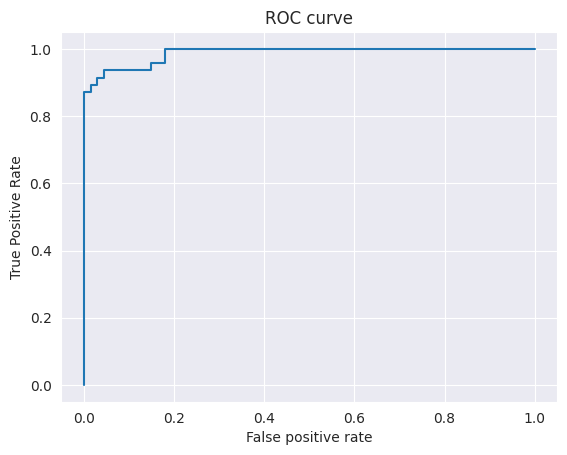

In [185]:
# First col is the p that a sample is class B, second col is p that sample is class M
y_pred_prob = model.predict_proba(x_test)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob[:, 1], pos_label = 'M')

plt.plot(fpr, tpr)
plt.title('ROC curve')
plt.xlabel('False positive rate')
plt.ylabel('True Positive Rate')
# todo: add legend?
plt.show()

We want to find the threshold which finds the balance between the TPR and the FPR.

Since our model is being used to classify tumorous cells, it is important to maximise the TPR.

NOTE: after changing the threshold, see if you are overfitting.

In [186]:
for idx, metric in enumerate(list(zip(tpr, fpr, thresholds))[1::]):
    tpr_, fpr_, threshold =  metric[0], metric[1], metric[2]
    print(f'''
    TPR: {tpr_}
    FPR: {fpr_}
    threshold: {threshold}
    threshold_idx: {idx + 1}
    ''')


    TPR: 0.02127659574468085
    FPR: 0.0
    threshold: 0.9999999946808908
    threshold_idx: 1
    

    TPR: 0.8723404255319149
    FPR: 0.0
    threshold: 0.8476201590387953
    threshold_idx: 2
    

    TPR: 0.8723404255319149
    FPR: 0.014925373134328358
    threshold: 0.7226493331273308
    threshold_idx: 3
    

    TPR: 0.8936170212765957
    FPR: 0.014925373134328358
    threshold: 0.7073529629252182
    threshold_idx: 4
    

    TPR: 0.8936170212765957
    FPR: 0.029850746268656716
    threshold: 0.7043426393090706
    threshold_idx: 5
    

    TPR: 0.9148936170212766
    FPR: 0.029850746268656716
    threshold: 0.6581227726049772
    threshold_idx: 6
    

    TPR: 0.9148936170212766
    FPR: 0.04477611940298507
    threshold: 0.48687692745535666
    threshold_idx: 7
    

    TPR: 0.9361702127659575
    FPR: 0.04477611940298507
    threshold: 0.43592001323573487
    threshold_idx: 8
    

    TPR: 0.9361702127659575
    FPR: 0.14925373134328357
    threshold: 0.186248

# Selecting a threshold

A TPR of 1 means that there are no FNs (M cells classified as B). But as TPR increases, so does FPR. We must find the balance of maximising TPR while minimizing FPR as FPs have a cost:
(e.g. patients having to go through intense chemotherapy as their benign tumour is treated as malignant)

I think a reasonable balance is given by threshold (with idx 8)

# AUC
AUC is the area under the ROC graph. **We can use AUC to compare two classification models**.

In [187]:
roc_auc_score(y_true=y_test, y_score=y_pred_prob[:, 1])

0.987297554779295

# Conclusions
- Make conclusions on AUC
- Create model with new threshold value and evaluate

# Testing model with new threshold
The new threshold has changed the TPR and FPR rates. How does this affect our models performance?

- Create precision-recall curve

In [193]:
new_threshold = thresholds[8]
new_predictions = []

for p in y_pred_prob[:, 1]:
    # Probability of M exceeds threshold, classify as M
    if p >= new_threshold:
        new_predictions.append('M')

    else:
        new_predictions.append('B')

new_predictions = pd.Series(new_predictions)

In [202]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           B       0.94      0.97      0.96        67
           M       0.96      0.91      0.93        47

    accuracy                           0.95       114
   macro avg       0.95      0.94      0.95       114
weighted avg       0.95      0.95      0.95       114



In [203]:
print(classification_report(y_test, new_predictions))

              precision    recall  f1-score   support

           B       0.96      0.96      0.96        67
           M       0.94      0.94      0.94        47

    accuracy                           0.95       114
   macro avg       0.95      0.95      0.95       114
weighted avg       0.95      0.95      0.95       114

